In [36]:
# %pip install torch==2.3.1 --index-url https://download.pytorch.org/whl/test/cu121

In [37]:
# %pip install lightgbm xgboost scikit-learn pandas numpy matplotlib seaborn cvxpy pybind11 riskfolio-lib yfinance scikit-optimize scipy shap stable-baselines3 tqdm

In [ ]:
# 5 hour [DONE] detect overfitting in XGboost model
# 5 hour [TODO] more analysis on final results performance. And frequency of MPM choosing HRP/ERC 
# 3 hour [TODO] more analysis on feature importance, and how it affects MPM choice
# 2 hour [TODO] consider MAPE of sharpe ratio, and it spred.
# 3 hour [DONE] use SHAP values to explain feature importance
# 3 hour [TODO] consider using a lightgbm model, and catboost model
# 1 day [TODO] change to backtesting framework, and add transaction costs
# 1 day [TODO] consider using a different risk measure, like CVaR
# 3 day [TODO] add more strategies and more frequency of rebalancing (daily, weekly, monthly)
# 1 day [DONE] add continuous portfolios weighting (not just 100% in one portfolio)
# 3 day [DONE] compare to direct investment in the index itself

# 21 days: project total 
# 2 days [TODO] create a poster
# 4 days [TODO] create a presentation
# 12 days: presentation and poster total
# 34 days: project total

In [89]:
from warnings import filterwarnings
import pandas as pd
import shap
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pickle as pkl
from main_utility_functions import *
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr, spearmanr
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import pandas as pd

filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=RuntimeWarning)
filterwarnings("ignore", category=UserWarning)

In [6]:


#load data from gathered from main_build_data
with open('data.pkl','rb') as f:  #rb is read binary code
    cov_period, index_, returns = pkl.load(f)

returns = returns[['EFA', 'EWJ', 'IWM', 'SPY', 'XLY']] #.iloc[:500] 
#basically convert all of returns to integer index
index_int=[x for x in range(len(returns.index))]
    
'''
IMPT VARIABLES:
    returns: a dataframe containing daily returns for each asset
    
    index_: Since features like semi_HRP requires measuring recent performance of hrp,
            2 diff daily portfolio returns are computed for hrp and erc where each hrp and erc is rebalanced monthly
            index_ decides when erc/hrp weights are applied (rebalancing)
            contains the INTEGER INDEX of the start of EVERY MONTH
    index_int: defines when weights and datapoints exists, contains the INTEGER INDEX of EVERY DAY
    index_trng: defines when MPM REBALANCING/STRATEGY CHOOSING occurs, contains INTEGER INDEX of month start, aft a period
                this is basically index_ but accounting for perf_period, sharpe_period, trng_period
    
    cov_period: defines the length of time backwards to compute weights and correlation matrix
    perf_period: defines the length of time that ret_b (returns backwards) calculates for performance features,
                and stats of assets universe
    sharpe_period: defines the length of time that ret_f(returns forwards) calcs for sharpe ratio
    trng_period: decides the number of data points and length of time considered for training
    
    weights_ERC: a dictionary containing weights for ERC, each set of weights is a Series indexed by assets
    weights_HRP: '' but for HRP

the dataframe.iloc[k:n] method acts like range and excludes n
the dataframe.loc[k:n] DOES NOT ACT like range, it INCLUDES n!!
'''

"\nIMPT VARIABLES:\n    returns: a dataframe containing daily returns for each asset\n    \n    index_: Since features like semi_HRP requires measuring recent performance of hrp,\n            2 diff daily portfolio returns are computed for hrp and erc where each hrp and erc is rebalanced monthly\n            index_ decides when erc/hrp weights are applied (rebalancing)\n            contains the INTEGER INDEX of the start of EVERY MONTH\n    index_int: defines when weights and datapoints exists, contains the INTEGER INDEX of EVERY DAY\n    index_trng: defines when MPM REBALANCING/STRATEGY CHOOSING occurs, contains INTEGER INDEX of month start, aft a period\n                this is basically index_ but accounting for perf_period, sharpe_period, trng_period\n    \n    cov_period: defines the length of time backwards to compute weights and correlation matrix\n    perf_period: defines the length of time that ret_b (returns backwards) calculates for performance features,\n                and

In [7]:
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import squareform
import riskfolio as rp
import riskfolio.src.RiskFunctions as rk
import riskfolio.src.AuxFunctions as af
import riskfolio.src.ParamsEstimation as pe
import riskfolio.src.DBHT as db
import riskfolio.src.GerberStatistic as gs
class HCPortfolio_modify(rp.HCPortfolio):
    def _hierarchical_clustering(
            self,
            model="HRP",
            linkage="ward",
            codependence="pearson",
            opt_k_method="twodiff",
            k=None,
            max_k=10,
            leaf_order=True,
        ):
            # Calculating distance
            if codependence in {
                "pearson",
                "spearman",
                "kendall",
                "gerber1",
                "gerber2",
                "custom_cov",
            }:
                dist = np.sqrt(np.clip((1 - self.codep) / 2, a_min=0.0, a_max=1.0))
            elif codependence in {"abs_pearson", "abs_spearman", "abs_kendall", "distance"}:
                dist = np.sqrt(np.clip((1 - self.codep), a_min=0.0, a_max=1.0))
            elif codependence in {"mutual_info"}:
                dist = af.var_info_matrix(self.returns, self.bins_info).astype(float)
            elif codependence in {"tail"}:
                dist = -np.log(self.codep).astype(float)

            # Hierarchical clustering
            dist = dist.to_numpy()
            dist = pd.DataFrame(dist, columns=self.codep.columns, index=self.codep.index)
            if linkage == "DBHT":
                # different choices for D, S give different outputs!
                D = dist.to_numpy()  # dissimilarity matrix
                if codependence in {
                    "pearson",
                    "spearman",
                    "kendall",
                    "gerber1",
                    "gerber2",
                    "custom_cov",
                }:
                    codep = 1 - dist**2
                    S = codep.to_numpy()  # similarity matrix
                else:
                    S = self.codep.to_numpy()  # similarity matrix
                (_, _, _, _, _, clustering) = db.DBHTs(
                    D, S, leaf_order=leaf_order
                )  # DBHT clustering
            else:
                self.p_dist = squareform(dist, checks=False)
                clustering = hr.linkage(self.p_dist, method=linkage, optimal_ordering=leaf_order)

            if model in {"HERC", "HERC2", "NCO"}:
                # optimal number of clusters
                if k is None:
                    if opt_k_method == "twodiff":
                        k, _ = af.two_diff_gap_stat(dist, clustering, max_k)
                    elif opt_k_method == "stdsil":
                        k, _ = af.std_silhouette_score(dist, clustering, max_k)
                    else:
                        raise ValueError(
                            "The only opt_k_method available are twodiff and stdsil"
                        )
            else:
                k = None

            return clustering, k

In [8]:
import time
'''PART 1: BUILD DAILY WEIGHTS, CORRELATION MATRIX FOR ERC AND HRP
For every day after the first year, build weights based on past year w/riskfolio
For each strategy and each day there is an associated corr matrix
'''

assets = returns.columns.tolist()
    
#the keys/index to each of these are integer indexes of returns

def compute_weight(i, ret_temp):
    # taking last year (252 trading days per year), EXCLUDING ith date
    

    
    # Build portfolio objects
    port_ERC = rp.Portfolio(returns=ret_temp)
    port_HRP = HCPortfolio_modify(returns=ret_temp)
    
    '''
    Riskfolio Parameters:
        
    Portfolio class:
        note that vanilla MV opt may give error (optimization will not return anyth)
        
        assets_stats:
            method_mu: method to estimate expected returns, 'hist' based on historical data.
            method_cov: method to estimate covariance matrix, 'gerber1' is a new method
        rp_optimization:
            note that rp_optimization uses ERC so the objective is already defined
            rm: risk measure, 'MV' is variance
            obj: objective, Sharpe/MinRisk/MaxRet/Utility (Utility involves l, strength of risk)
    
    Hierarchical Clustering Portfolio (HCPortfolio) class:
        optimization:
            model: Could be HRP or HERC
            codependence: similarity/distance matrix used to build clusters
    '''
    port_ERC.assets_stats(method_mu='hist', method_cov='ledoit')
    
    #note that the optimization method will return a single column dataframe, each row per asset
    #select the column as a series
    port_dict = {}
    # for rm in ['MV', 'SLPM', "CVaR"]:
    #     port_dict[rm + "_rp"] = port_ERC.rp_optimization(rm=rm)['weights']
    #     port_dict[rm + "_sharpe"] = port_ERC.optimization(rm=rm, obj = "Sharpe")['weights']
    
    
    port_dict["MV"] = port_ERC.rp_optimization(rm="MV")['weights']
    port_dict["CVaR"] = port_ERC.optimization(rm="CVaR", obj = "MaxRet")['weights']
    
    # for model in ['HRP', 'HERC', 'HERC2', 'NCO']:
    port_dict["NCO"] = port_HRP.optimization(model="NCO",codependence='gerber1',method_cov='ledoit', rm='MV')['weights']
    
    
    #add the cophenetic corr coeff, ONLY applies for HRP to measure quality of clustering
    #note that if the number of assets is too small, coph might give NaN
    coph = coph_corr(port_HRP)
    
    #add correlation(corr) matrix, both covariance matrix(cov) and corr are df
    #NOTE, if method for getting cov is same for HRP and ERC, they will have the same corr matrix
    #doesnt matter if u choose port_ERC.cov or port_HRP.cov
    corr = rp.AuxFunctions.cov2corr(port_HRP.cov)
    
    
    
    return i, port_dict, corr, coph

res = Parallel(n_jobs=-1)(
    delayed(compute_weight)(i, ret_temp = returns.iloc[i-cov_period:i]) for i in tqdm(range(cov_period+1, len(returns.index)))
)

100%|██████████| 4529/4529 [01:41<00:00, 44.59it/s]


In [9]:
weights_port,corr,coph = {},{},{}
for i, port_dict, corr_, coph_ in sorted(res, key=lambda x: x[0]):
    weights_port[i] = port_dict
    corr[i] = corr_
    coph[i] = coph_

In [10]:
model_list = list(weights_port[list(weights_port.keys())[0]].keys())

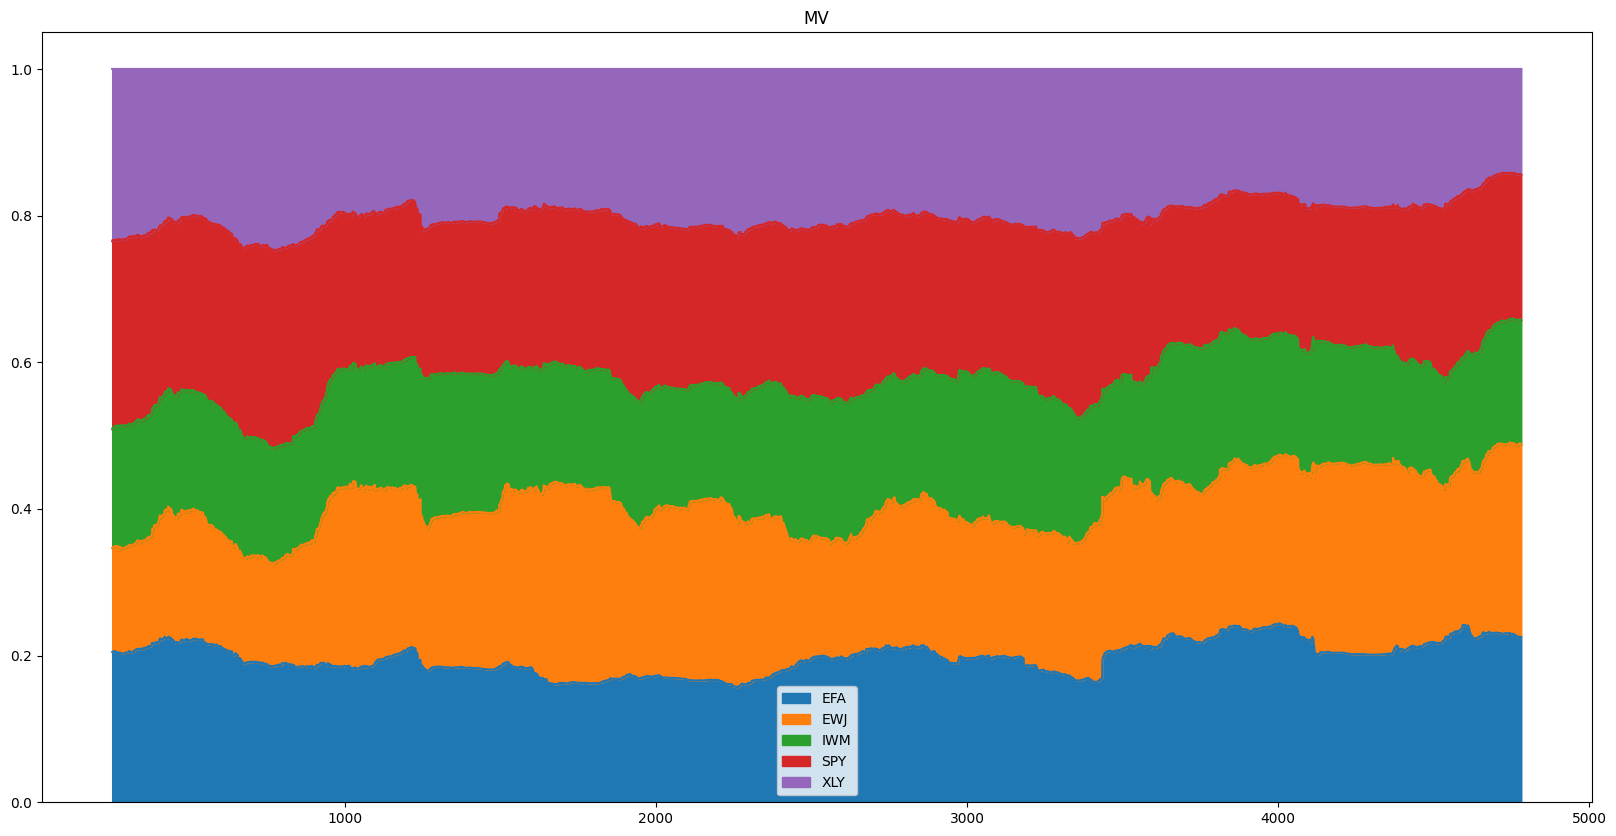

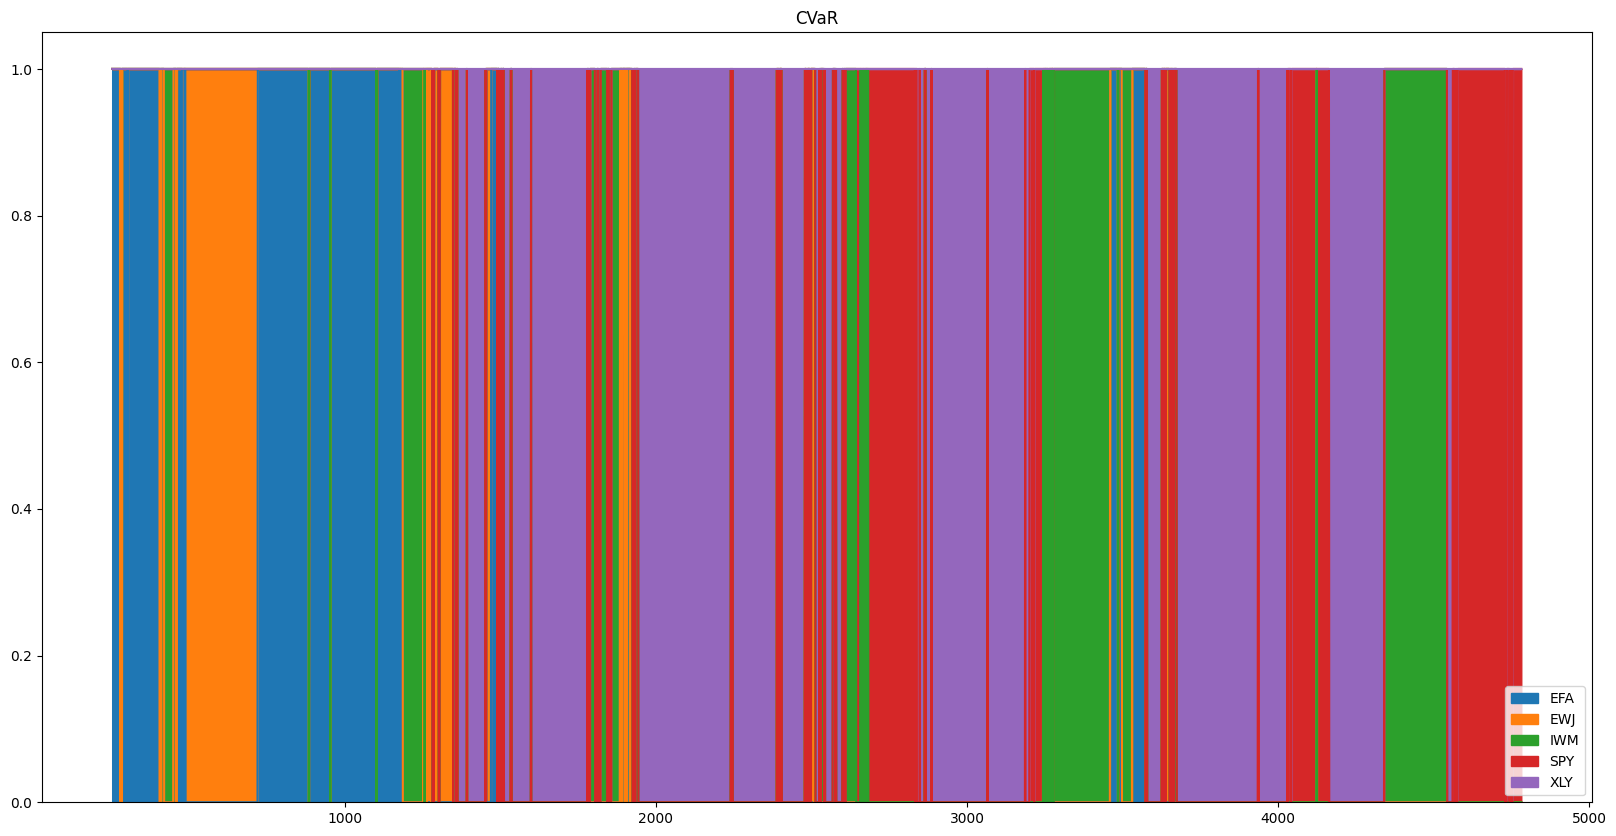

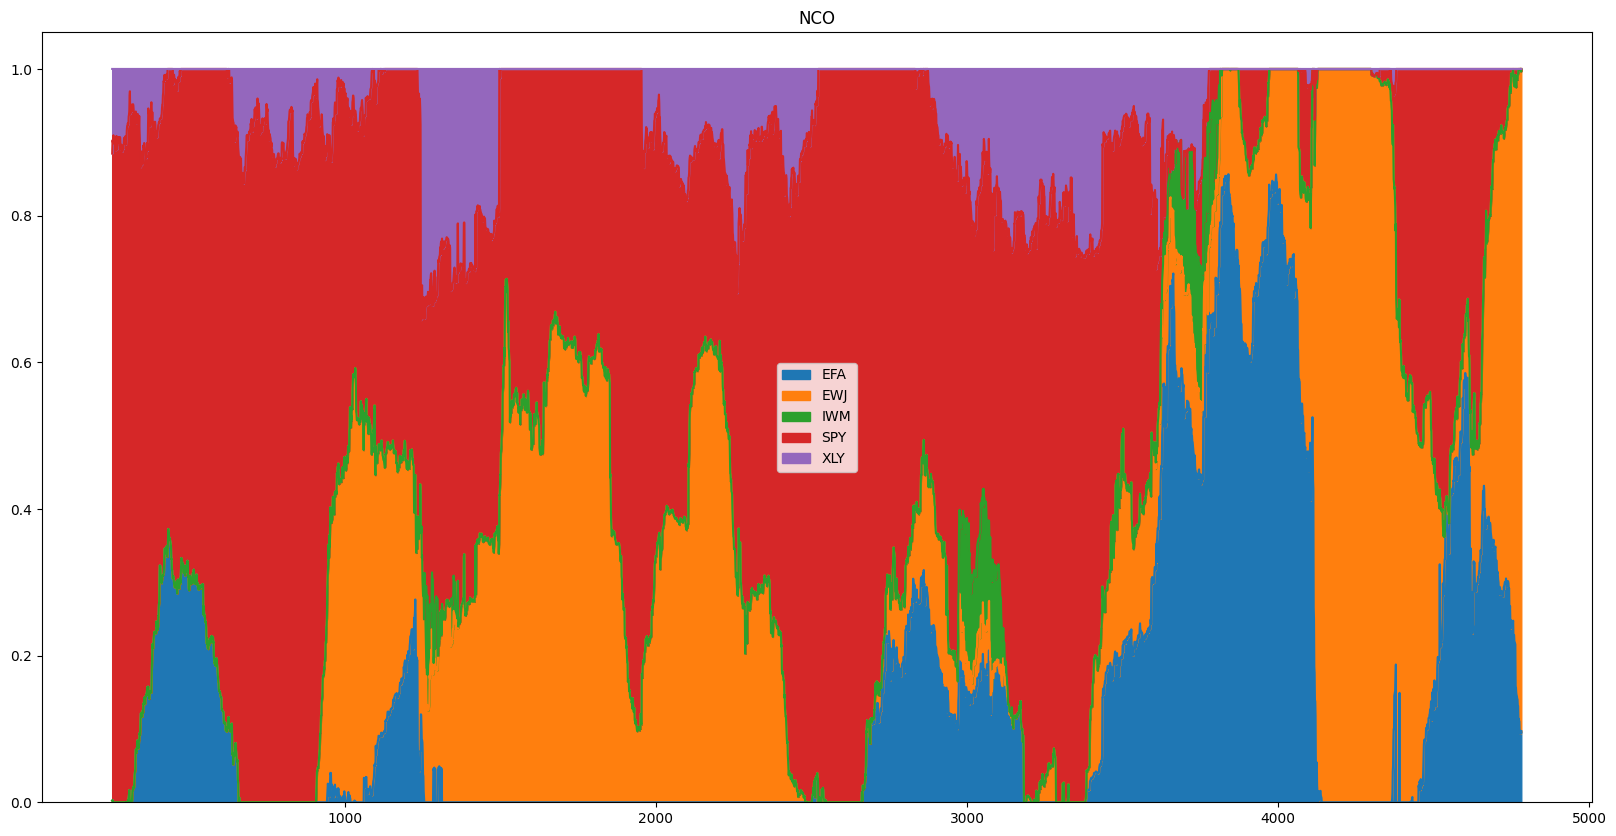

In [11]:
for model in model_list:
    t = pd.DataFrame([i[model] for i in weights_port.values()], index = weights_port.keys())
    t.index = t.index.astype(int)
    t.plot(kind = "area",stacked = True, figsize = (20,10))
    plt.title(model)
    plt.show()

In [12]:
'''PART 2: CREATING X AND Y DATASET FOR XGB
        if index is at 1026, perf_period=2, sharpe_period=3
        ret_b computes data from 1024 to day 1025, perf_period number of days backwards
        ret_f computes data from 1026 to 1028, sharpe_period number of days backwards

    X DATA (FEATURES):
        features are computed using returns from perf_period backwards (ret_b)
        features like semi_ERC with 'ERC' or 'HRP' attached at the end, measure ret_b for that strategy only
        asset universe stats measure ret_b for each asset individually, and combines these stats
        while mean/std_corr, cond, coph, det measure data regarding that date's corr matrix
        
        SEMI_STD_ERC/HRP:
            measures the std of returns below mean return only
        
        AVE_RETURN_ERC/HRP:
            get mean return of that portfolio's daily returns in perf_period
        
        REALISED_VOLATILITY_ERC/HRP:
            alternative measure of variance
            
        MAXIMUM DRAWDOWN:
            longest consecutive decrease (peak-to-trough) in perf_period, divided by the peak
       
        MONTHLY ASSET UNIVERSE STATS:
            mean_assets_mean: get mean return in each asset. Take average across assets
            std_assets_mean: get std return in each asset. Take average across assets
            mean_assets_SD: get mean return in each asset. Take std across assets
            std_assets_SD: get std return in each asset. Take std across assets
            mdd_assets_mean: get mdd in each asset. Take ave across assets
            mdd_assets_SD: get mdd in each asset. Take std across assets
        
        MEAN_CORR, STD_CORR:
           take the mean and std of upper triangular elems in correlation matrix. Measures
           average correlation btwn assets and how varied these corr are
        
        CONDITION NUMBER, DETERMINANT:
            some characteristics about the correlation matrix
        
        COPHENETIC CORRELATION COPEFFICIENT:
            measures quality of clustering
        
        Conditional Value at Risk (CVaR)
        First or Second Lower Partial Moment of a returns series
        Average Drawdown (ADD)
        Drawdown at Risk (DaR) of a returns
        Conditional Drawdown at Risk (CDaR)
        Ulcer Index (UCI)
        Sharpe Ratio (SR)
        Sortino Ratio (SOR)
        Omega Ratio (ORM)
    
    Y DATA (LABELS): 
        SHARPE_ERC/HRP:
            sharpe at index 1026 gives sharpe ratio from day1026 to day 1027 if sharpe_period=2
            estimated using daily returns
'''

portfolio_specific_data = [pd.DataFrame(index=index_int,
    columns=[
        'sharpe',
        'semi'
        'ave_return'
        'rea_vol', 
        'mdd'
        ],
    dtype='float64') for _ in model_list]

general_data=pd.DataFrame(index=index_int,
                  columns=[
                            'mean_assets_mean', 'std_assets_mean',
                            'mean_assets_SD', 'std_assets_SD',
                            'mdd_assets_mean', 'mdd_assets_SD',
                            'mean_corr',
                            'std_corr',
                            'cond',
                            'coph_coef',
                            'det'],
                  dtype='float64'
)

'''Generate portfolio returns(series) for ERC and HRP separately'''


port_ret_list = []
for model in model_list:
    model_ret = port_ret(
        pd.DataFrame([weight_i[model] for weight_i in weights_port.values()], index = weights_port.keys()).T,
        returns,
        index_
    )
    port_ret_list.append(model_ret)

#both are one month, which is 21 trading days
#I believe sharpe_period should represent the duration between each rebalancing date
perf_period=21
sharpe_period=21

'''
Weird indexing to make it such that it doesnt run into NaN values, yet fill data as much as possible
because model needs to calc perf_period backwards and sharpe_period forwards worth of data

first day of data is the first elem of index_ + perf_period number of days
last day of data is the last elem of index_ - sharpe_period number of days (final i that range iterates over)
u add +1 to range because iloc functions like range, last elem in range is len(returns.index)-sharpe_period
'''
def compute_features(i):
    '''calc ERC first'''
    for port_i, port_ret_i in enumerate(port_ret_list):
    #ret_f is returns (sharpe_period) days forwards, INCLUDING current date
        ret_f=port_ret_i.iloc[i:i+sharpe_period]
        portfolio_specific_data[port_i].at[ i, 'sharpe']=get_sharpe(ret_f,'daily')
        #ret_b is returns (perf_period) days backwards, EXCLUDING current date
        ret_b=port_ret_i.iloc[i-perf_period:i]
        portfolio_specific_data[port_i].loc[ i, ['semi','ave_return','rea_vol','mdd']] = \
                        semi_std(ret_b) ,ret_b.dropna().mean(), rea_vol(ret_b), mdd(ret_b)

    '''get stats on all assets'''
    #first compute mean and std vertically for each asset, then do another mean horizontally
    general_data.loc[ i , ['mean_assets_mean', 'std_assets_mean',
                          'mean_assets_SD', 'std_assets_SD',
                          'mdd_assets_mean', 'mdd_assets_SD',] ]\
            =stats_asset_univ(returns.iloc[i-perf_period:i])
    
    '''calc stats based on Correlation matrix(same for both HRP and ERC)'''
    general_data.loc[ i , ['mean_corr','std_corr','cond','det'] ] = stats_corr(corr[i])
    
    '''add in cophenetic stats'''
    general_data.loc[ i , 'coph_coef'] = coph[i]
    

for i in tqdm(range(index_[0]+perf_period, len(returns.index)-sharpe_period+1)):
    compute_features(i)

100%|██████████| 4470/4470 [00:29<00:00, 149.45it/s]


In [13]:
y = [port_i["sharpe"] for port_i in portfolio_specific_data]
X = [pd.concat([port_i.drop(columns = ["sharpe"]), general_data], axis=1) for port_i in portfolio_specific_data]

In [75]:
'''PART 3: TRAINING XGBOOST: CREATE MPM CHOICES
trng period is the number of data points that XGB considers. 
It also is the number of days that XGB looks back, since each day has one data point
'''

#choose trng_period in number of days
trng_period=252 * 8
embrago_period=1
val_period=5
#indexes of ret where weights_MPM will have data
#since index_ is ascending order, simply pick the suitable indexes
index_trng=[x for x in index_ if x > index_[0]+perf_period+trng_period ]
pref_list = ["train_MAPE",
    "train_corr",
    "val_MAPE",
    "val_corr",
    "test_pred",
    "test_true"
]
#prep the feature importances
feat_impt = [pd.DataFrame(columns=X[0].columns, index=index_trng, dtype='float64') for _ in model_list]
shap_impt = [pd.DataFrame(columns=X[0].columns, index=index_trng, dtype='float64') for _ in model_list]
val_shap_impt = [pd.DataFrame(columns=X[0].columns, index=index_trng, dtype='float64') for _ in model_list]
pred_sharpe = pd.DataFrame(columns=model_list, index=index_trng, dtype='float64')
df_pref_models = [pd.DataFrame(columns = pref_list, index=index_trng, dtype='float64') for _ in model_list]


weights_stregies = "weights_avg" #"select_best" or "weights_avg"
#build MPM weight dict
weights_MPM={}

# create model instance
reg = [xgb.XGBRegressor(objective='reg:squarederror', importance_type='gain',  eval_metric='mae', early_stopping_rounds=100) for _ in model_list]

for i in tqdm(index_trng): #these are integer indexes where MPM strat choosing occurs
    #note that loc includes last elem! make sure not to include the X you want to predict
    single_step_time = {}
    sharpe_pred_list = []
    for model_i in range(len(model_list)):
        # get training data
        train_slice = slice(i-trng_period, i-1-embrago_period-val_period)
        train_X, train_y = X[model_i].loc[train_slice], y[model_i].loc[train_slice]
        
        #get validation data
        val_slice = slice(i-1-val_period, i-1)
        val_X, val_y = X[model_i].loc[val_slice], y[model_i].loc[val_slice]
        
        #get test data
        test_X, test_y = X[model_i].loc[[i]], y[model_i].loc[[i]]
        
        #fit model
        reg[model_i].fit(
            train_X, train_y,
            eval_set=[(val_X, val_y)],
            verbose = False
        )
        
        #make prediction on ith month
        sharpe_pred_train = reg[model_i].predict(train_X)
        sharpe_pred_val = reg[model_i].predict(val_X)
        sharpe_pred_test = reg[model_i].predict(test_X)
        
        # performance on validation set and test set
        pred_sharpe.loc[i, model_list[model_i]] = sharpe_pred_test[0]
        
        # 
        perf = {
            "train_MAPE": mean_absolute_percentage_error(train_y, sharpe_pred_train),
            "train_corr": pearsonr(train_y, sharpe_pred_train)[0],
            "val_MAPE": mean_absolute_percentage_error(val_y, sharpe_pred_val),
            "val_corr": pearsonr(val_y, sharpe_pred_val)[0],
            "test_pred": sharpe_pred_test[0],
            "test_true": test_y.values[0]
        }
        df_pref_models[model_i].loc[i] = perf
        
        # feature importance and shap values
        
        explainer = shap.Explainer(reg[model_i])
        test_shap_values = explainer(val_X)
        val_shap_values = explainer(test_X)
        
        feat_impt[model_i].loc[i] = reg[model_i].feature_importances_ 
        shap_impt[model_i].loc[i] = np.mean(np.abs(test_shap_values.values), axis = 0)
        val_shap_impt[model_i].loc[i] = np.mean(np.abs(val_shap_values.values), axis = 0)
        
    #get the best strategy
    if weights_stregies == "weights_avg":
        weights = np.array(pred_sharpe.loc[i, :]).flatten()
        weights[weights < 0] = 0
        if np.sum(weights) == 0:
            best_model = np.zeros(returns.shape[1])
        else:
            best_model = np.average([weights_port[i][model_list[model_i]] for model_i in range(len(model_list))], axis=0, weights=weights)

        # best_model = np.average([weights_port[i][model_list[model_i]] for model_i in range(len(model_list))], axis=0, weights=weights)
    elif weights_stregies == "select_best":
        best_model = weights_port[i][model_list[np.argmax(pred_sharpe.loc[i, :])]]
    
    weights_MPM[i] = best_model

100%|██████████| 117/117 [01:23<00:00,  1.40it/s]


# Performance Report

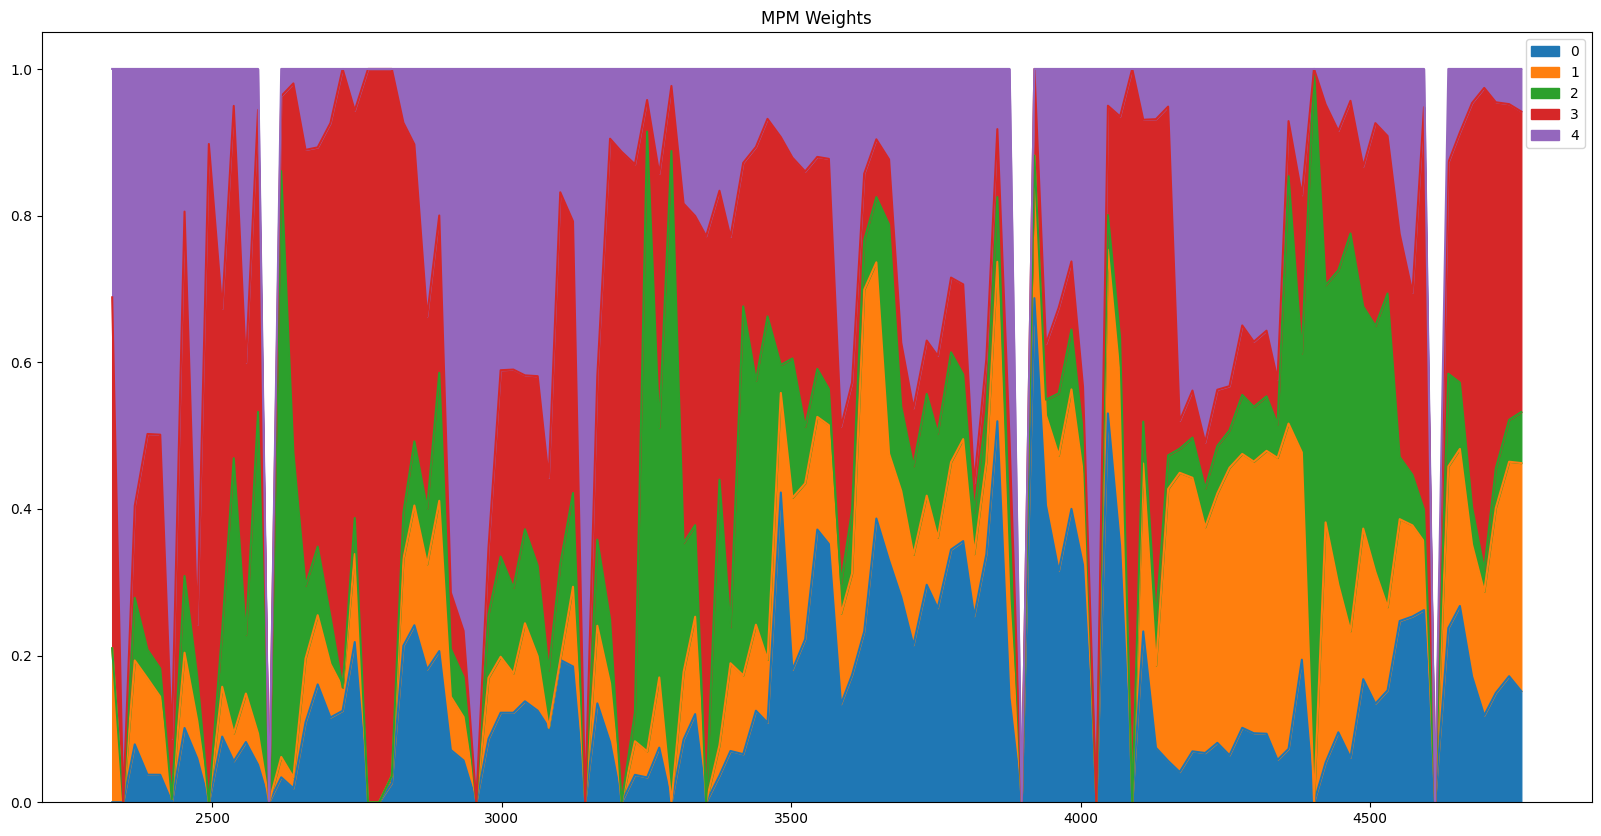

In [76]:
pd.DataFrame(weights_MPM).T.plot(kind = "area",stacked = True, figsize = (20,10))
plt.title("MPM Weights")
plt.show()

In [194]:
def port_ret(weights, ret, index_, fee_rate = 0.0001):
    '''
    this function applies a set of weights to daily returns of an asset universes
    and creates a portfolio return. note that it makes use of the theoretical property that
    ret(portfolio)= sum[asset_weight * ret(asset)]
    
    Parameters
    ----------
    weights : dictionary
        keys are the integer index of returns while each item is a set of weights for that day
        e.g.
        1105: [w1,w2,w3]
        1206: [w1_new,w2_new,w3_new]
        This will mean that weight applies on ret from 1105 to 1205, and 1206 is a diff set of weights
    ret :  a dataframe, DAILY RETURNS OF EACH TICKER
    index_ : list
        These are integer indexes of ret, where REBALANCING(CHOOSING ERC/HRP) happens
        note that index_ may be a subset of the index of weights
        because XGboost needs some months of data, can only start ltr

    Returns
    -------
    series
        daily portfolio returns, COMBINED into one value
        note that port_returns will automatically make nan all the returns up to the first date in index_
    '''
    
    ret=ret.copy()
    pred_w = weights[index_[0]].to_numpy()
    for i in range(len(index_)):
        if i!=len(index_)-1: #if the index is not the last index
            r_w = weights[index_[i]].to_list() * ret.iloc[index_[i]:index_[i+1]]
            
            w = weights[index_[i]].to_numpy()
            fee = np.sum(np.abs(w - pred_w)) / 2 * fee_rate
            pred_w = w
            
            ret.iloc[index_[i]:index_[i+1]] = r_w - fee
        else: #if last number in index_, just apply weights all the way to last row
            ret.iloc[index_[i]:]=weights[index_[i]].to_list()*ret.iloc[index_[i]:]
    #sum all the returns horizontally
    #note that if rows are NaN, summing will make them zero!!
    ret=ret.sum(axis=1)
    #make all rows nan up to first rebalancing date, not including first date
    ret.iloc[:index_[0]]=np.nan
    return ret #will contain nan, not fully filled

In [195]:
'''PART 4: FINAL BACKTEST

Measures of performance: 
1. Cumulative Return
2. Compound Annual Growth Rate
3. Annualised Sharpe Ratio constructed from daily returns
4. Annualised Sharpe Ratio constructed from monthly returns
5. Annualised Sharpe Ratio constructed from yearly returns

Important Variables:
    comp: a dataframe containing performance metrics across strategies
    perf: a float, the performance gain measured by Sharpe_MPM compared to Average(Sharpe_ERC and Sharpe_HRP)
    
    pr_df: the dataframe containing daily returns for each strategy
    feat_impt: the dataframe containing feature importances
    uni_corr: dict, contains corr matrix, mean of corrs and the std of corrs

'''
weights_ALL = {
    model: pd.DataFrame([wp[model] for _, wp in weights_port.items()], index = weights_port.keys(), columns = returns.columns).loc[weights_MPM.keys()] 
        for model in model_list
}
weights_ALL = {**weights_ALL, 
               "MPM": pd.DataFrame([weights_MPM[i] for i in weights_MPM.keys()], index = weights_MPM.keys(), columns = returns.columns)
}
keys = list(weights_ALL.keys())
#portfolio prices
pr_df=pd.DataFrame([],columns=keys)

#display results as dataframe
comp=pd.DataFrame(columns=['Cumulative Return',
                        'Compound Annual Growth Rate',
                         'Annual Sharpe(Daily)',
                         'Annual Sharpe(Monthly)',
                         'Annual Sharpe(Yearly)'],
                  index=keys)

#get performance metrics
for strat in keys:
    pr=port_ret(weights_ALL[strat].T, returns, index_trng).dropna()
    #update portfolio returns
    pr_df[strat]=pr
    #update values
    comp.loc[strat]=[cum_ret(pr),
                   cagr(pr),
                   get_sharpe(pr,'daily'),
                   get_sharpe(pr,'monthly'),
                   get_sharpe(pr,'yearly')]

#perfomance increase of MPM against ave of ERC and HRP, made using daily sharpe estimates
ave=comp.loc[keys,'Annual Sharpe(Daily)'].mean()
perf=( (comp.loc['MPM','Annual Sharpe(Daily)']-ave)/ave )*100



There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!


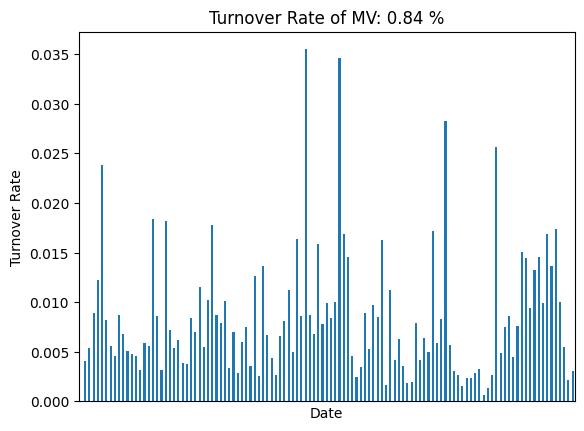

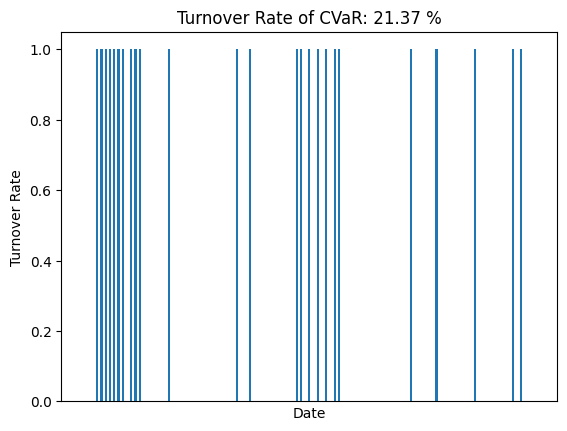

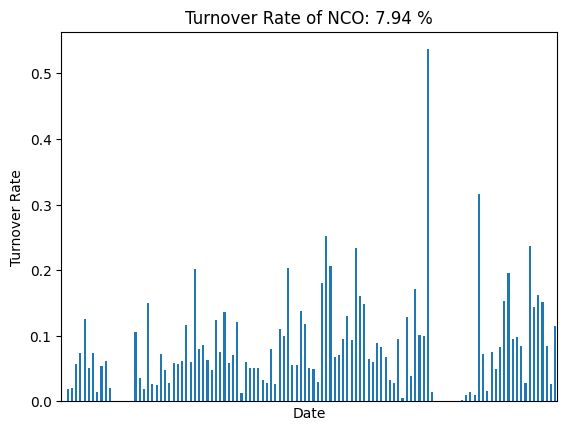

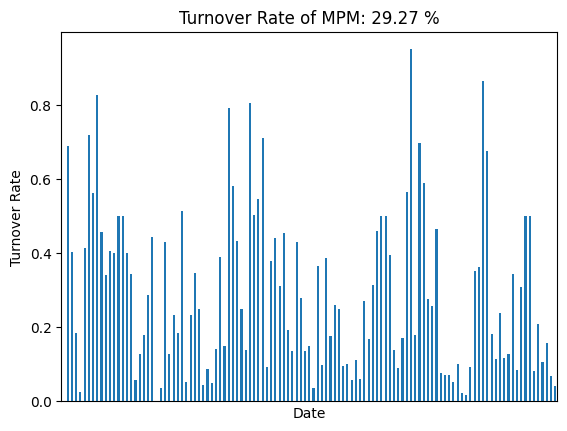

In [149]:
# turnover rate
tr_rate = {}
for model in weights_ALL.keys():
    weight_diff = weights_ALL[model].diff().abs().sum(axis=1) / 2
    tr_rate[model] = weight_diff
    turnover_rate = weight_diff.mean()
    weight_diff.plot(kind = "bar", xticks = [], xlabel = "Date", ylabel = "Turnover Rate", title = f"Turnover Rate of {model}: {turnover_rate *  100:.2f} %")
    plt.show()

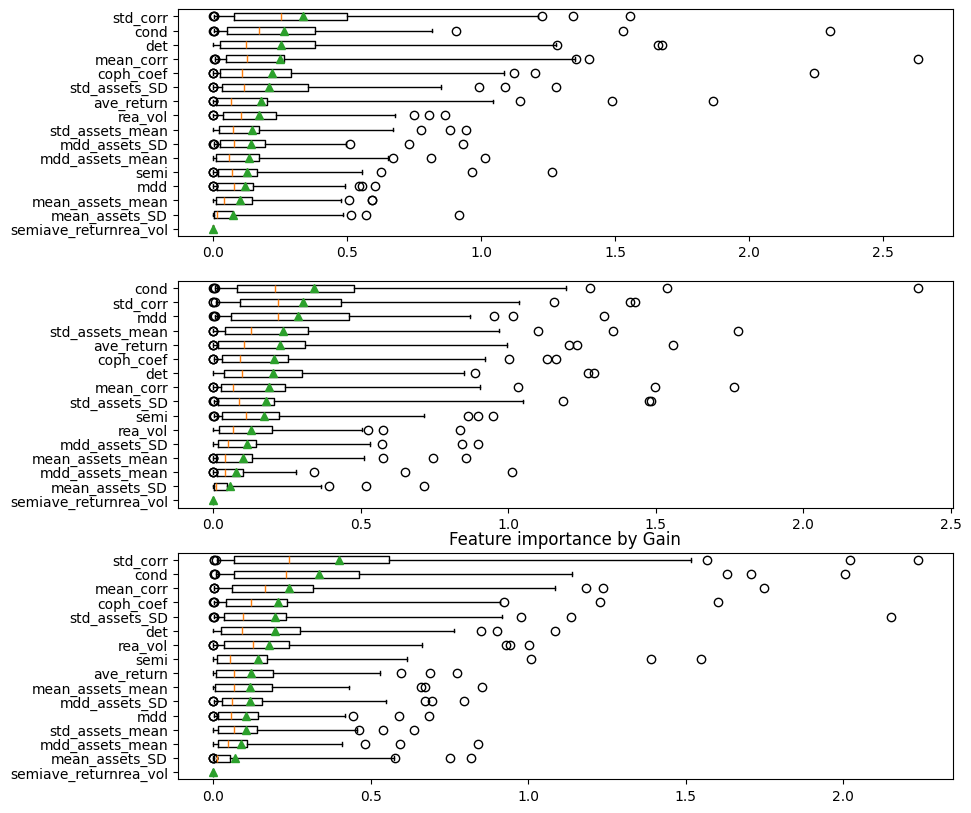

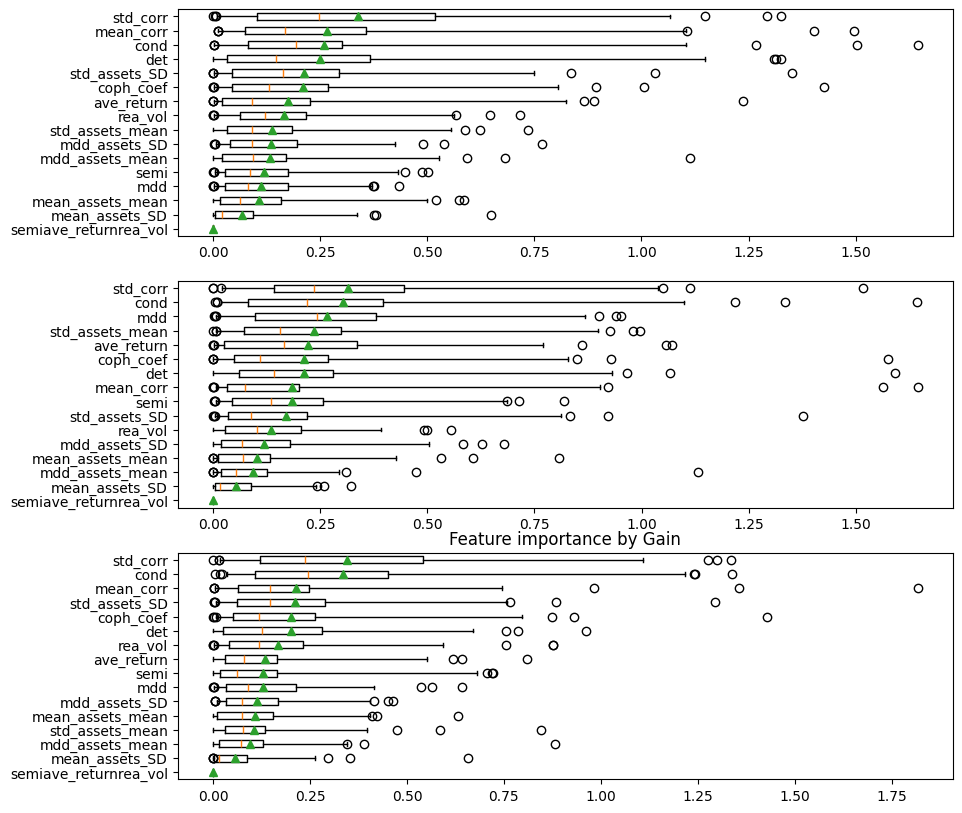

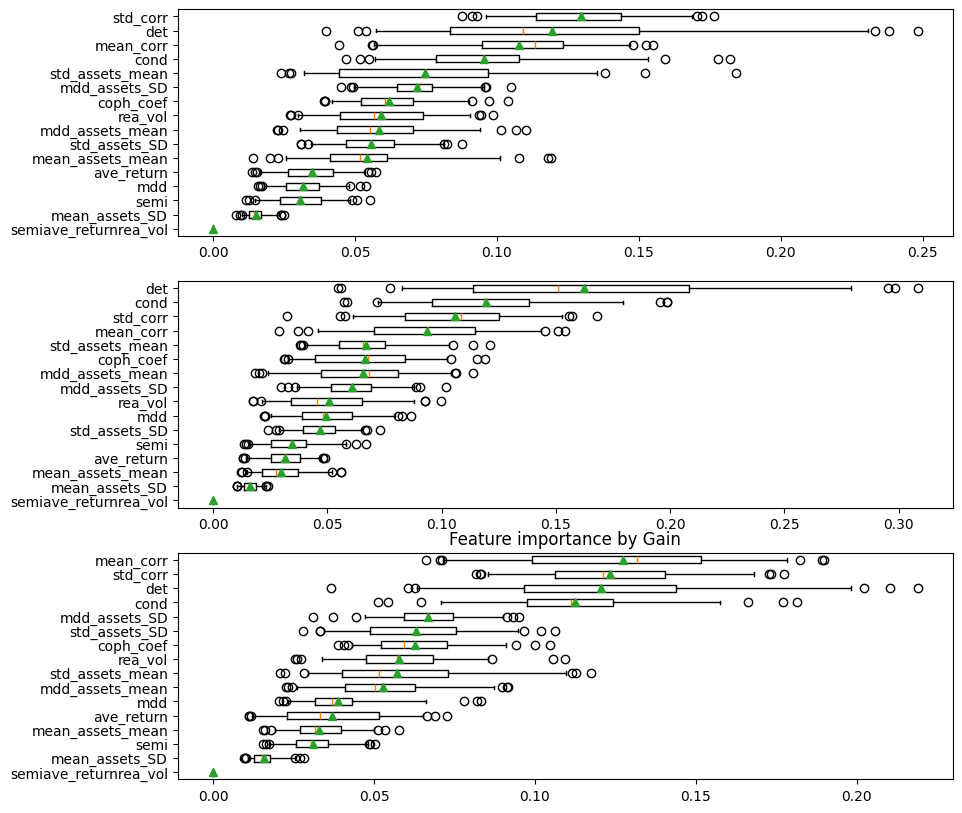

In [162]:
'''Plotting feature importance (boxplot)'''

#first sort feat_impt's columns, in terms of descending mean.
#i.e. leftmost column has highest mean
features_importance_all = [val_shap_impt, shap_impt, feat_impt]
for feature in features_importance_all:
    fig, axs = plt.subplots(nrows=len(model_list), figsize=(10, 10))
    feature_importance_order = []
    plt.title('Feature importance by Gain')
    for i,axs in enumerate(axs):
        feat = feature[i].mean().sort_values()
        feat_plot = feature[i].dropna().reindex(feat.index, axis=1)
        #whiskers cover 5th to 98th perc of data
        axs.boxplot(x=feat_plot,vert=False,labels=feat_plot.columns,whis=(2,98),showmeans=True)
        feature_importance_order.append(feat)
    fig.show()

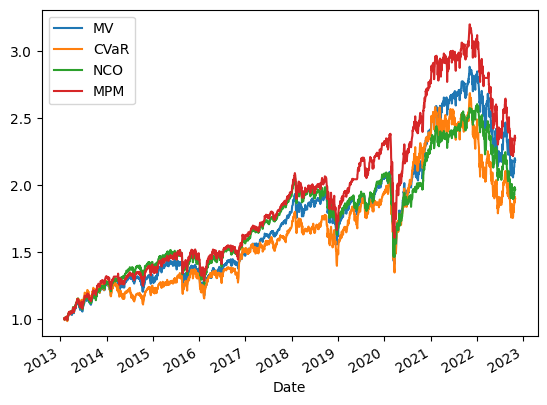

In [196]:
#show portfolio price history for strategies
port = (pr_df+1).cumprod()
port.plot()

'''Examining this asset universe, using Correlation matrix of ALL historical returns'''
uni_corr_stats=stats_uni_corr(returns.dropna())

In [173]:
(pr_df+1).cumprod()

,MV,CVaR,NCO,MPM
Date,,,,
2013-02-01,1.005752,1.005785,1.006193,1.006092
2013-02-04,0.995643,0.993417,0.998227,0.997041
2013-02-05,1.001833,1.003990,1.004704,1.004531
2013-02-06,1.006072,1.006184,1.009029,1.008330
2013-02-07,1.003997,1.003990,1.008831,1.007639
...,...,...,...,...
2022-10-25,2.184155,1.896282,1.972874,2.351443
2022-10-26,2.188226,1.881996,1.985418,2.351494
2022-10-27,2.172979,1.871946,1.962186,2.333379


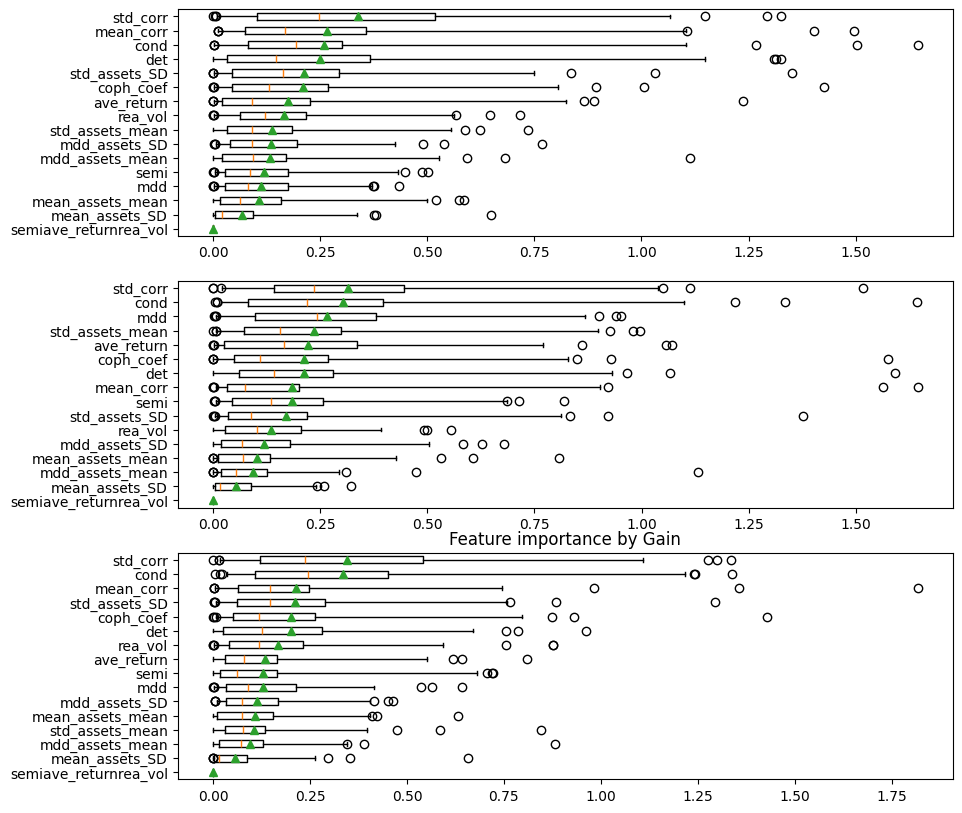

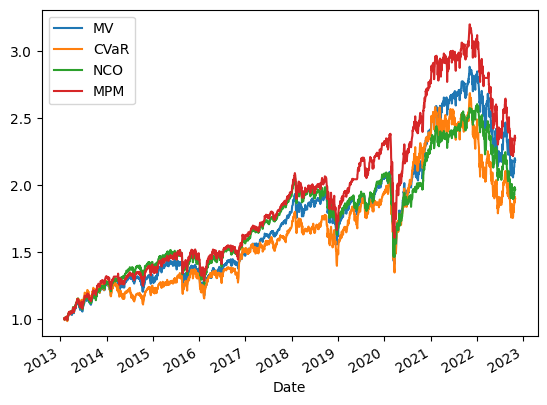

In [80]:
'''Plotting feature importance (boxplot)'''

#first sort feat_impt's columns, in terms of descending mean.
#i.e. leftmost column has highest mean
fig, axs = plt.subplots(nrows=len(model_list), ncols=1, figsize=(10, 10))
feature_importance_order = []
plt.title('Feature importance by Gain')
for i,axs in enumerate(axs):
    feat = shap_impt[i].mean().sort_values()
    feat_plot = shap_impt[i].dropna().reindex(feat.index, axis=1)
    #whiskers cover 5th to 98th perc of data
    axs.boxplot(x=feat_plot,vert=False,labels=feat_plot.columns,whis=(2,98),showmeans=True)
    feature_importance_order.append(feat)
fig.show()

In [110]:
def get_performance(df):
    t = (df[["test_pred", "test_true"]].dropna()).values
    print(f'train:\t {df["train_MAPE"].mean():.4f}\t {df["train_corr"].mean():.4f}')
    print(f'val:\t {df["val_MAPE"].mean():.4f}\t {df["val_corr"].mean():.4f}')
    print(f'test:\t {mean_absolute_percentage_error(t[:, 0], t[:, 1]):.4f}\t {pearsonr(t[:, 0], t[:, 1])[0]:.4f}')
    print()
[get_performance(df) for df in df_pref_models];

train:	 1.3990	 0.8477
val:	 2.1481	 0.2231
test:	 3.2367	 0.1467

train:	 5.8017	 0.8590
val:	 40.0220	 0.3206
test:	 6.5911	 0.1506

train:	 2.0217	 0.8405
val:	 2.8123	 0.1515
test:	 5.5363	 0.1138



In [104]:
gt = pd.DataFrame([df["test_true"] for df in df_pref_models], index = model_list)
pred = pd.DataFrame([df["test_pred"] for df in df_pref_models], index = model_list)

print("how well it order the portfolio relative to each other:",gt.corrwith(pred, method='pearson').mean())

how well it order the portfolio relative to each other: 0.13450740036799907


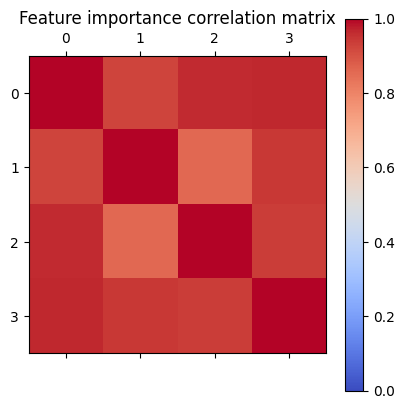

In [85]:
plt.matshow(pr_df.corr(method='pearson'), cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar()
plt.title('Feature importance correlation matrix')
plt.show()

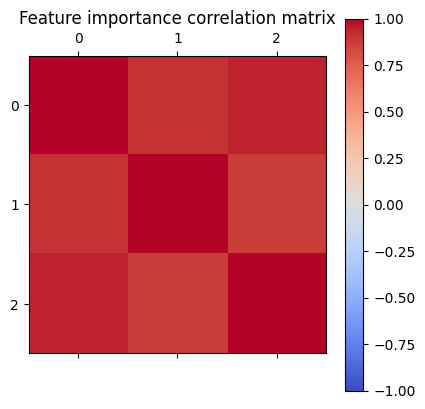

In [172]:
df_feature_importance = pd.DataFrame(feature_importance_order, index = model_list ).T
plt.matshow(df_feature_importance.corr(method="spearman"), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Feature importance correlation matrix')
plt.show()

In [86]:
print(f"perfomance increase of MPM against ave of others, made using daily sharpe estimates {perf:.4f}%")
comp

perfomance increase of MPM against ave of others, made using daily sharpe estimates 14.5339%


,Cumulative Return,Compound Annual Growth Rate,Annual Sharpe(Daily),Annual Sharpe(Monthly),Annual Sharpe(Yearly)
MV,1.190079,0.083796,0.561743,0.592591,0.963605
CVaR,0.902637,0.068256,0.438824,0.439177,0.665127
NCO,0.970197,0.072089,0.524354,0.570457,0.884787
MPM,1.355827,0.091942,0.611824,0.646605,0.927206


<Axes: xlabel='Date'>

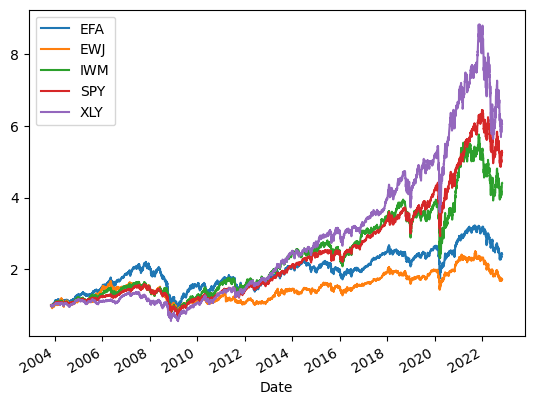

In [82]:
(1 + returns.dropna()).cumprod().plot()

In [83]:
asset_perf_stats = pd.DataFrame(index = returns.columns, columns = ['Cumulative Return', 'CAGR', 'Sharpe(Daily)', 'Sharpe(Monthly)', 'Sharpe(Yearly)'])
for asset in returns.columns:
    pr = returns.dropna()[asset]
    asset_perf_stats.loc[asset] = [cum_ret(pr), cagr(pr), get_sharpe(pr,'daily'), get_sharpe(pr,'monthly'), get_sharpe(pr,'yearly')]
asset_perf_stats

There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!


,Cumulative Return,CAGR,Sharpe(Daily),Sharpe(Monthly),Sharpe(Yearly)
EFA,1.426975,0.047843,0.324531,0.339801,0.432457
EWJ,0.730399,0.029325,0.2429,0.27052,0.377307
IWM,3.405384,0.081293,0.444241,0.468971,0.629154
SPY,4.263092,0.09148,0.553076,0.643981,0.735598
XLY,5.051323,0.099538,0.548078,0.609606,0.735492


# Predictive power of Sharpe ratio

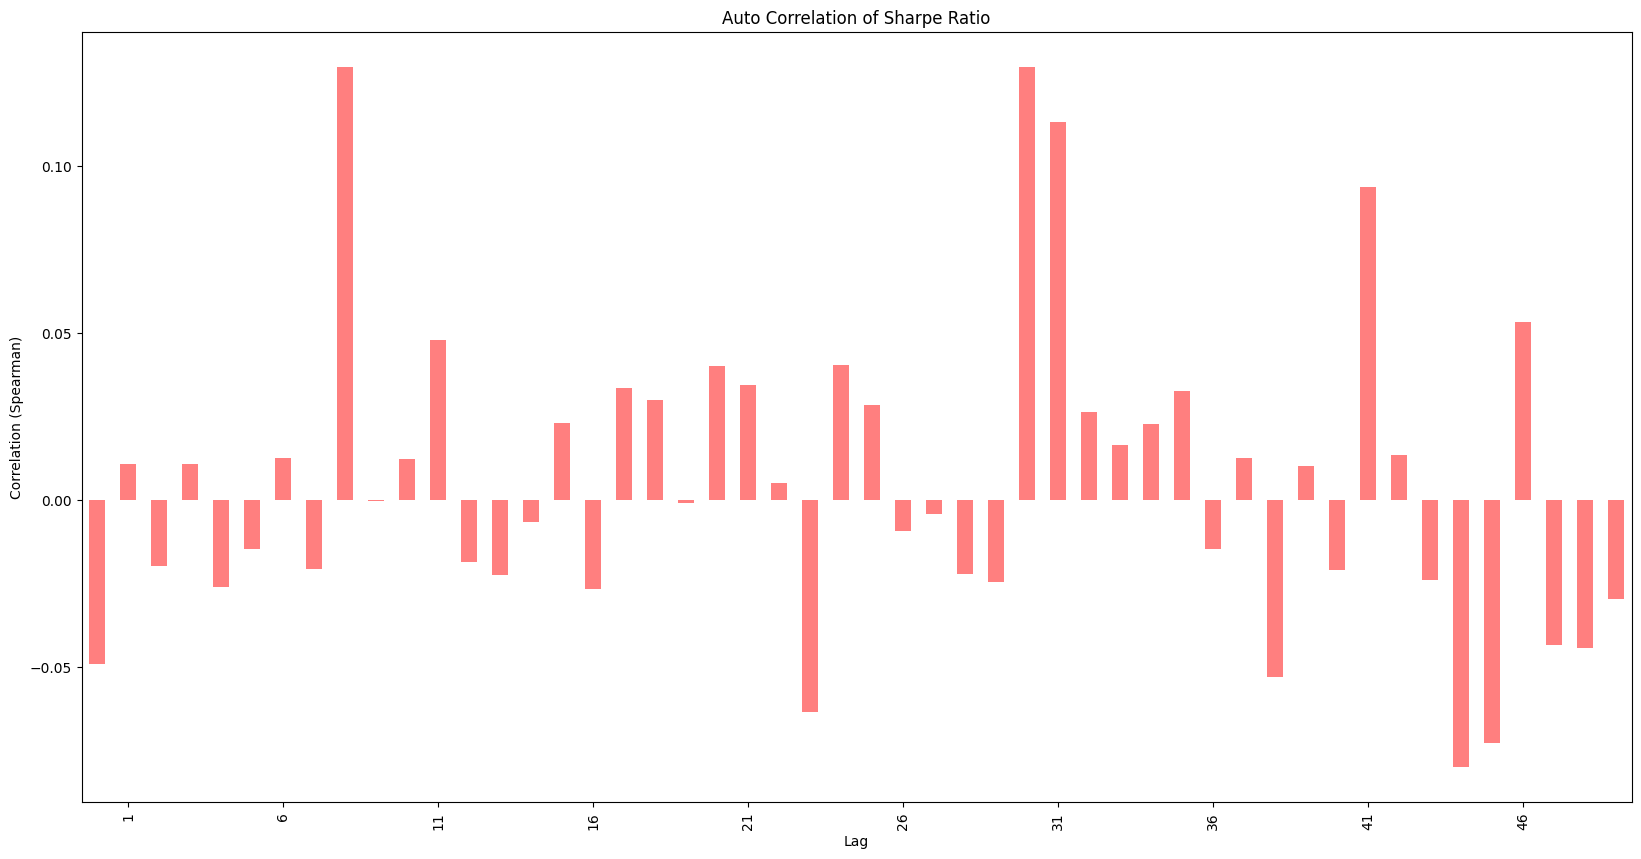

mean: 0.0054, std: 0.0450


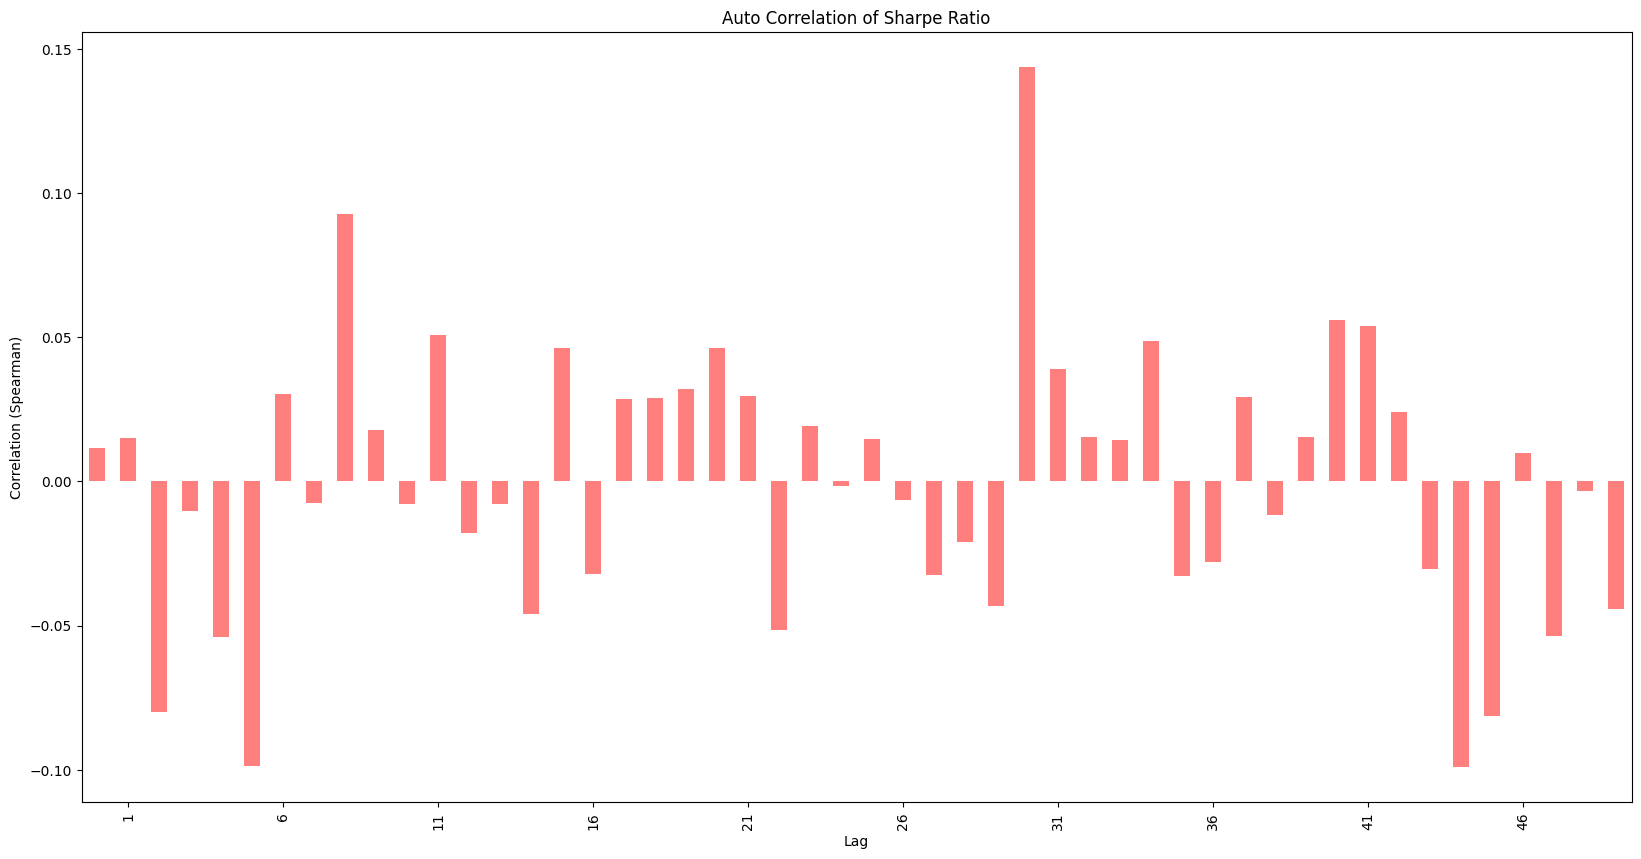

mean: 0.0002, std: 0.0463


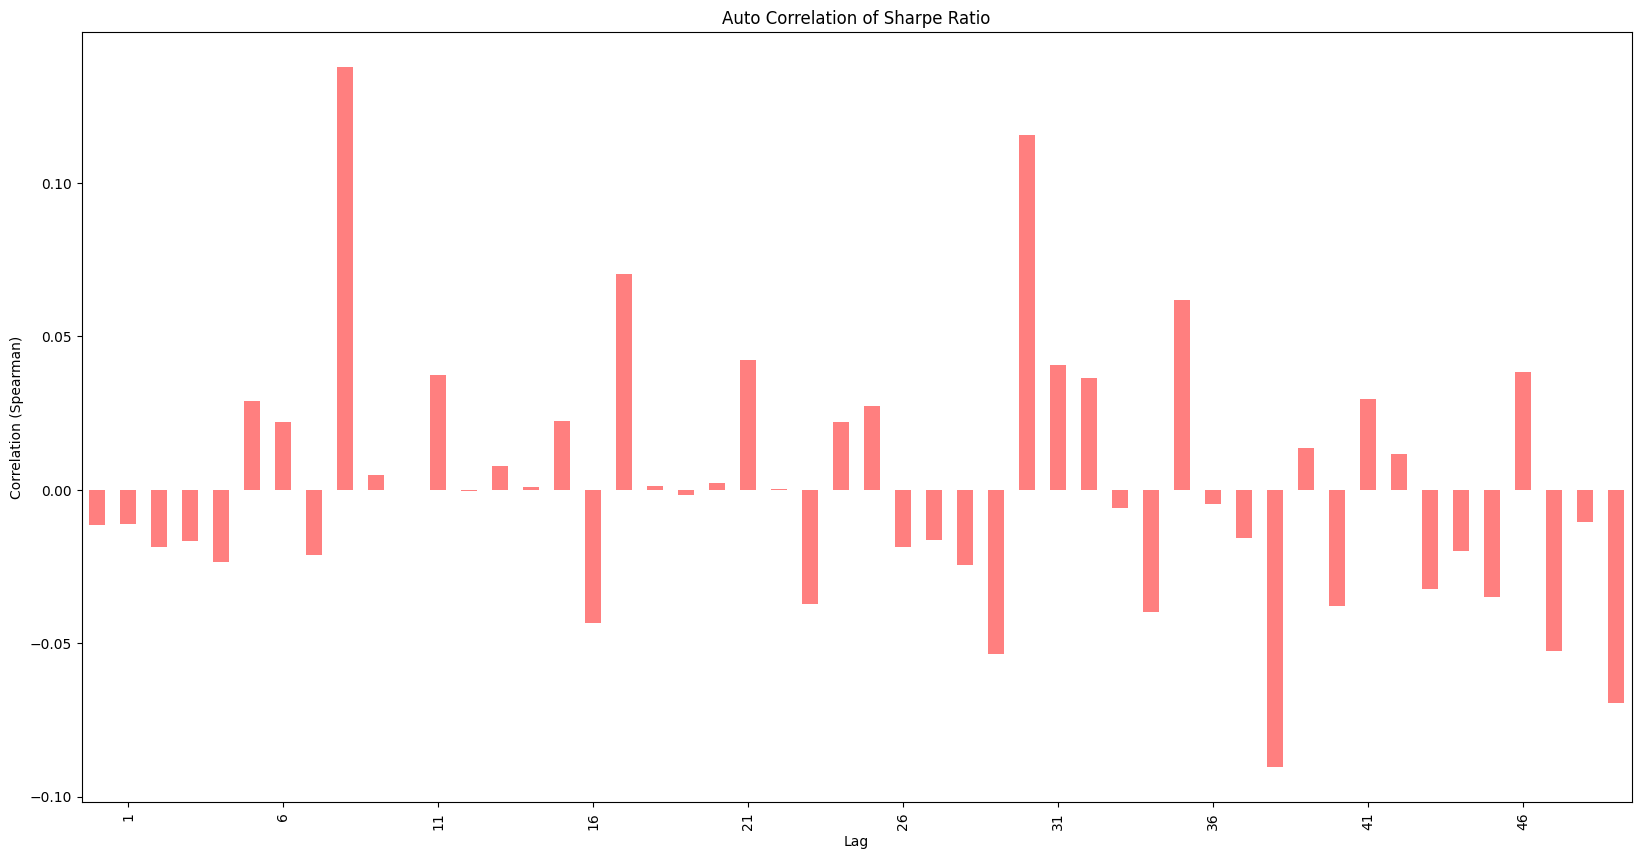

mean: 0.0012, std: 0.0410


In [87]:
# import spearman correlation
def sharpe_ratio_auto_corr(df_ret, min_lag=1, max_lag=10):
    # df_sharpe = pd.DataFrame(df_ret.rolling(window=21).apply(lambda x: x.mean()/x.std(ddof=1))).dropna()
    df_sharpe = pd.DataFrame(df_ret.groupby(pd.Grouper(freq='W')).apply(lambda x: x.mean()/x.std(ddof=1))).dropna()
    if max_lag > len(df_sharpe):
        print(f"max_lag is too large, setting to {len(df_sharpe)}")
        max_lag = len(df_sharpe)
    if min_lag > max_lag:
        print(f"min_lag is too large, setting to {1}")
        min_lag = 1
    auto_corr = pd.Series(index = range(min_lag, max_lag+1), dtype = np.float64, name = "Auto Correlation")
    for i in range(min_lag, max_lag+1):
        corr = df_sharpe.corrwith(df_sharpe.shift(i))
        auto_corr[i] = corr
    auto_corr.plot(
        kind='bar',
        color = 'red',
        alpha = 0.5,
        figsize=(20,10),
        title='Auto Correlation of Sharpe Ratio', 
        ylabel='Correlation (Spearman)', 
        xlabel='Lag',
        xticks = range(min_lag, max_lag+1, int((max_lag-min_lag)/10 + 1))
    )
    plt.show()
    print(f"mean: {np.mean(auto_corr):.4f}, std: {np.std(auto_corr):.4f}")
    return auto_corr

for model in model_list:
    _ = sharpe_ratio_auto_corr(pr_df[model], min_lag=1, max_lag=50)

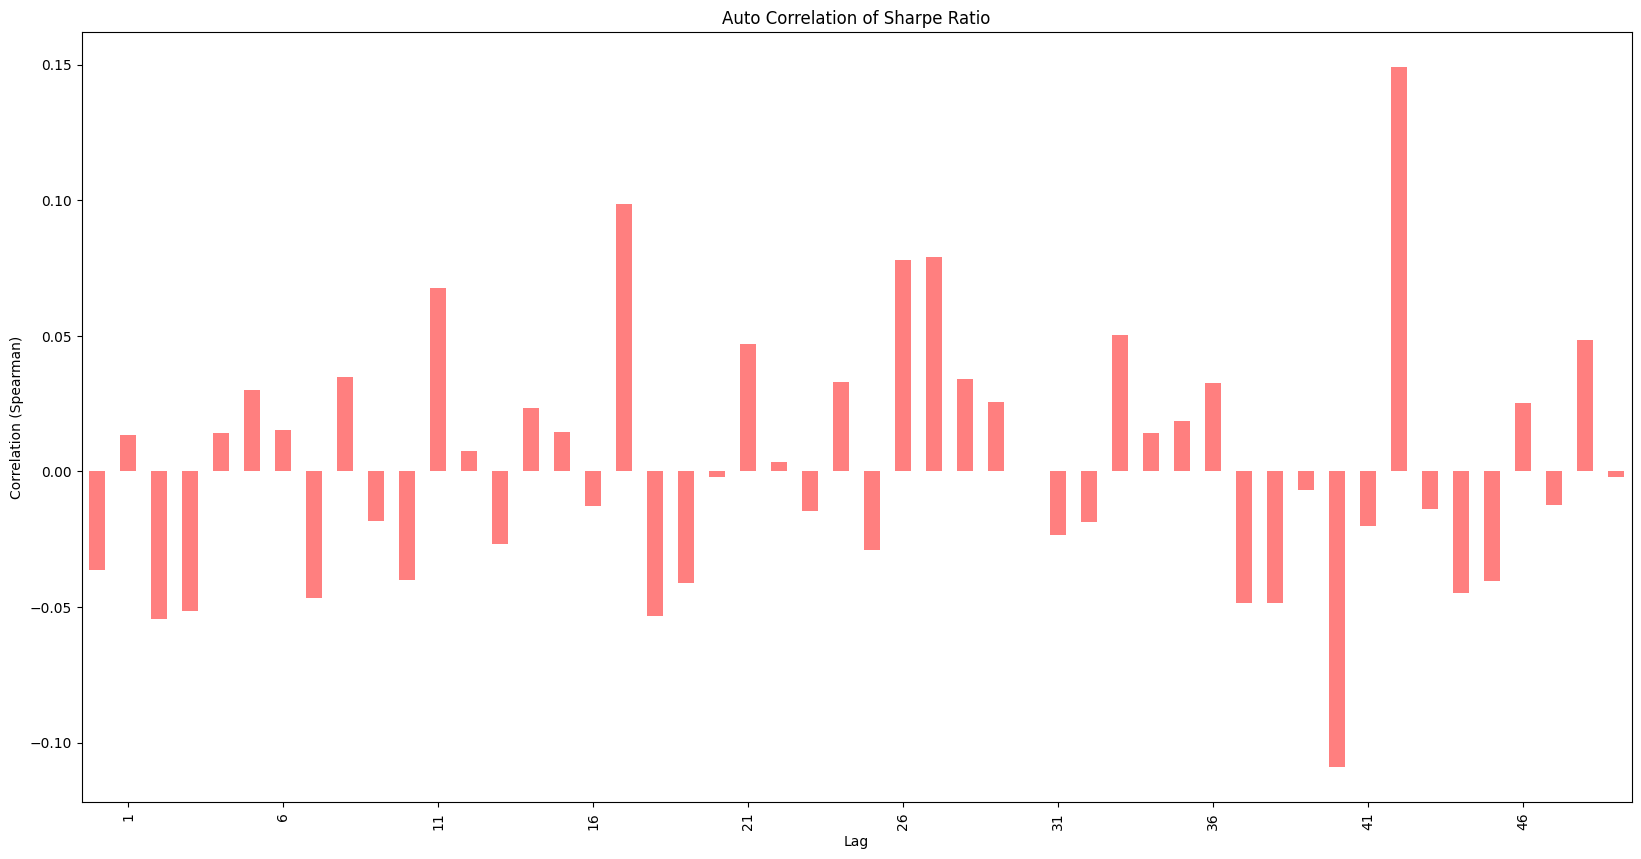

mean: 0.0028, std: 0.0456


In [143]:
auto_corr = sharpe_ratio_auto_corr(pr_df["MPM"], min_lag=1, max_lag=50)